In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np

In [3]:
#行動データ
work_detail = pd.read_csv('../../datas/groupby_widedata/work_detail.csv')
work_env = pd.read_csv('../../datas/groupby_widedata/work_env.csv')
#fitbitデータ
calories = pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/calories_day.csv')
floors = pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/floors_day.csv')
heart = pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/heart_day.csv')
minutesFairlyActive= pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/minutesFairlyActive_day.csv')
minutesLightlyActive = pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/minutesLightlyActive_day.csv')
minutesSedentary = pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/minutesSedentary_day.csv')
minutesVeryActive = pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/minutesVeryActive_day.csv')
steps = pd.read_csv('../../datas/fitbit_preprocessed_data/agg_for_day/steps_day.csv')
sleep = pd.read_csv('../../datas/fitbit_preprocessed_data/sleep.csv')
#アンケートデータ
morning_bodyfatigue = pd.read_csv('./analyse_data/questionaire_data/morning_bodyfatigue.csv')
morning_dams = pd.read_csv('./analyse_data/questionaire_data/morning_dams.csv')
night_w_bodyfatigue = pd.read_csv('./analyse_data/questionaire_data/night_w_bodyfatigue.csv')
night_w_dams = pd.read_csv('./analyse_data/questionaire_data/night_w_dams.csv')
night_w_eval = pd.read_csv('./analyse_data/questionaire_data/night_w_eval.csv')
night_w_productivity = pd.read_csv('./analyse_data/questionaire_data/night_w_productivity.csv')
night_w_recover = pd.read_csv('./analyse_data/questionaire_data/night_w_recover.csv')
night_w_workenga = pd.read_csv('./analyse_data/questionaire_data/night_w_workenga.csv')
#天気データ
weather = pd.read_csv('../../datas/attribute_weater.csv')

,Unnamed: 0,user_id,date,floor_mean,floor_median,floor_var,date_plus1
0,0,1,2021-01-07,0.000000,0.0,0.000000,2021-01-08
1,1,1,2021-01-08,0.000000,0.0,0.000000,2021-01-09
2,2,1,2021-01-09,0.000000,0.0,0.000000,2021-01-10
3,3,1,2021-01-10,0.000000,0.0,0.000000,2021-01-11
4,4,1,2021-01-11,0.000000,0.0,0.000000,2021-01-12
...,...,...,...,...,...,...,...
2407,2407,100,2021-01-29,0.026667,0.0,0.039333,2021-01-30
2408,2408,100,2021-01-30,0.052222,0.0,0.107392,2021-01-31
2409,2409,100,2021-01-31,0.000000,0.0,0.000000,2021-02-01
2410,2410,100,2021-02-01,0.000000,0.0,0.000000,2021-02-02


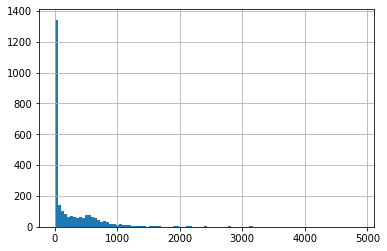

In [4]:
steps['step_var'].hist(bins=100)
floors

In [5]:
night_w_dams['positive_score'] = night_w_dams['haturatu']+night_w_dams['tanosii']+night_w_dams['uresii']/3
night_w_dams['depressive_score'] = night_w_dams['kurai']+night_w_dams['iyana']+night_w_dams['sizunda']/3
night_w_dams['anxious_score'] = night_w_dams['kigakari']+night_w_dams['fuan']+night_w_dams['sinpai']/3

In [6]:
def to_datetime_jp2(x, datetime):
    x.index = pd.DatetimeIndex(x[datetime], name=datetime).tz_convert('Asia/Tokyo')
    x[datetime] = x.index
    x = x.reset_index(drop=True)
#     x[datetime] = x[datetime]+timedelta(days=1)
    x['date'] = x[datetime].dt.date
    return x

In [7]:
activity = activity.reset_index(drop=True)

NameError: name 'activity' is not defined

In [8]:
value_unique = activity['activity'].unique()
zero_td = dt.timedelta(days=0, hours=0, minutes=0,
                        seconds=0, milliseconds=0, microseconds=0)
activity['started_at'] = pd.to_datetime(activity['started_at'])
activity['finished_at'] = pd.to_datetime(activity['finished_at'])
for i in range(len(value_unique)):
    activity['{}'.format(value_unique[i])] = zero_td  #timedeltaの０で埋める
    activity.loc[activity['activity']==value_unique[i],value_unique[i]]=activity['finished_at']-activity['started_at']  #行動の継続時間を計算
    activity['{}'.format(value_unique[i])] = activity['{}'.format(value_unique[i])].dt.total_seconds()/60  #
activity['date'] = activity['finished_at'].dt.date

NameError: name 'activity' is not defined

In [180]:
activity = activity.groupby(['date','user_id'],as_index=False).sum()

## アンケートデータの前処理

In [741]:
# def hour9():
attribute_weather = pd.read_csv('../../datas/attribute_weater.csv')
attribute_weather = attribute_weather[['Date', 'ave_temperature', 'max_temperature',
       'mini_temperature', 'sum_rainfall', 'sunlight_time', 'ave_windspeed',
       'max_windspeed', 'ave_vaporpressure', 'ave_cloudcover', 'weather_6to18',
       'weather_18to6', 'locate', 'user_id', 'sex', 'age']]

In [176]:
labeling(morning_bodyfatigue, 'value_hukai')
labeling(morning_bodyfatigue, 'value_boyake')
labeling(morning_bodyfatigue, 'value_nemuke')
labeling(morning_dams, 'positive_score')
labeling(morning_dams, 'depressive_score')
labeling(morning_dams, 'anxious_score')

labeling(night_w_bodyfatigue, 'value_hukai')
labeling(night_w_bodyfatigue, 'value_boyake')
labeling(night_w_bodyfatigue, 'value_nemuke')
labeling(night_w_dams, 'positive_score')
labeling(night_w_dams, 'depressive_score')
labeling(night_w_dams, 'anxious_score')
#夜アンケー自己評価
labeling(night_w_eval, 'kouritu')
labeling(night_w_eval, 'syutyu')
labeling(night_w_eval, 'yoteidori')
labeling(night_w_eval, 'jubun_comu')
labeling(night_w_eval, 'kouritu_comu')
labeling(night_w_eval, 'idea')
labeling(night_w_eval, 'seika')
#夜アンケー生産性
labeling(night_w_productivity, 'study_new')
labeling(night_w_productivity, 'decide_doing')
labeling(night_w_productivity, 'paformance')
labeling(night_w_productivity, 'absent_by_problem')
#夜アンケーリカバリー経験
labeling(night_w_recover, 'value_recover')
#夜アンケーワークエンゲージメント
labeling(night_w_workenga, 'workenga_score')

## それぞれのデータをマージ

In [177]:
#いらないカラムを捨てる
work_detail = work_detail[['date', 'user_id', 
       '管理者兼作業者', '企画業務', 'ノンコア業務（自身が本来担当ではない業務）', '管理者',
       '比較的慣れており，定型化できている業務', 'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務',
       '作業者/参加者', '管理の業務', '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務',
       '事務業務（サポート業務、経理業務など）', '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）']]
work_env = work_env[['date', 'user_id',
       '家（その他）', 'どちらでもない', '一人', '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）',
       '快適', '職場外のワークスペース', '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外',
       '不快', '非常に快適', '職場外ワークスペース', '非常に不快']]
calories = calories[[ 'user_id', 'date', 'mets_mean', 'calory_mean',
       'mets_median', 'calory_median', 'mets_var', 'calory_var', 'date_plus1']]
floors = floors[[ 'user_id', 'date', 'floor_mean', 'floor_median',
       'floor_var', 'date_plus1']]
heart = heart[['user_id', 'date', 'heart_mean', 'heart_median',
       'heart_var', 'date_plus1']]
minutesFairlyActive = minutesFairlyActive[['user_id', 'date', 'minutesFairlyActive_mean',
       'minutesFairlyActive_median', 'minutesFairlyActive_var', 'date_plus1']]
minutesLightlyActive = minutesLightlyActive[['user_id', 'date', 'minutesLightlyActive_mean',
       'minutesLightlyActive_median', 'minutesLightlyActive_var',
       'date_plus1']]
minutesSedentary = minutesSedentary[['user_id', 'date', 'minutesSedentary_mean',
       'minutesSedentary_median', 'minutesSedentary_var', 'date_plus1']]
minutesVeryActive = minutesVeryActive[[ 'user_id', 'date', 'minutesVeryActive_mean',
       'minutesVeryActive_median', 'minutesVeryActive_var', 'date_plus1']]
steps = steps[[ 'user_id', 'date', 'step_mean', 'step_median', 'step_var',
       'date_plus1']]
sleep = sleep[['Unnamed: 0', 'date', 'user_id', 'sleep', 'Unnamed: 0.1', 'datetime',
       'dateTime', 'sleep_1', 'sleep_2', 'sleep_3']]
morning_bodyfatigue = morning_bodyfatigue[[ 'date', 'user_id', 'value_nemuke',
       'value_hukai', 'value_boyake', 'value_nemuke_label',
       'value_hukai_label', 'value_boyake_label']]
morning_dams = morning_dams[[ 'user_id', 'Date_jp',  'date',
       'positive_score_label', 'depressive_score_label',
       'anxious_score_label']]
night_w_bodyfatigue = night_w_bodyfatigue[['user_id', 'date',
       'value_hukai_label', 'value_boyake_label', 'value_nemuke_label']]
night_w_dams = night_w_dams[[ 'date', 'user_id', 'positive_score_label',
       'depressive_score_label', 'anxious_score_label']]
night_w_eval = night_w_eval[['datetime_jp', 'user_id',
       'value_eval', 'hour', 
       'date', 'kouritu_label', 'syutyu_label', 'yoteidori_label',
       'jubun_comu_label', 'kouritu_comu_label', 'idea_label', 'seika_label']]
night_w_productivity = night_w_productivity[['datetime_jp', 'user_id',
       'date', 'study_new_label', 'decide_doing_label', 'paformance_label',
       'absent_by_problem_label']]
night_w_recover = night_w_recover[['datetime_jp', 'user_id', 
       'date', 'value_recover_label']]
night_w_workenga = night_w_workenga[['datetime_jp', 'user_id', 
        'date','workenga_score_label']]


In [178]:
activity = activity[[ 'user_id','date', '食事（業務時間外）',
       '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）', '移動', 'Web会議', 'その他', '業務外作業',
       '対面会議', '共同作業（コミュニケーションを伴う）', '電話（会議）']]

In [588]:
# アクティビティデータのマージ
merged_act = pd.merge(activity_1, work_detail_1, on=['date','user_id'],how='left')
# merged_act = pd.merge(merged_act, merged_act, on=['date', 'user_id'],how='left')

# work_env.to_csv('./work_data/work_env.csv')

In [222]:
#fitbitデータ
merged_fitbit = pd.merge(calories, floors, on=['date', 'user_id'], how='left')
merged_fitbit = pd.merge(merged_fitbit, heart, on=['date', 'user_id'], how='left')
merged_fitbit = pd.merge(merged_fitbit, minutesFairlyActive, on=['date', 'user_id'], how='left')
merged_fitbit = pd.merge(merged_fitbit, minutesLightlyActive, on=['date', 'user_id'], how='left')
merged_fitbit = pd.merge(merged_fitbit, minutesSedentary, on=['date', 'user_id'], how='left')
merged_fitbit = pd.merge(merged_fitbit, minutesVeryActive, on=['date', 'user_id'], how='left')
merged_fitbit = pd.merge(merged_fitbit, steps, on=['date', 'user_id'], how='left')
merged_fitbit = pd.merge(merged_fitbit, sleep, on=['date', 'user_id'], how='left')
# calories.to_csv('./fitbit/calories.csv')
# floors.to_csv('./fitbit/floors.csv')
# heart.to_csv('./fitbit/heart.csv')
# minutesFairlyActive.to_csv('./fitbit/minutesFairlyActive.csv')
# minutesLightlyActive.to_csv('./fitbit/minutesLightlyActive.csv')
# minutesSedentary.to_csv('./fitbit/minutesSedentary.csv')
# minutesVeryActive.to_csv('./fitbit/minutesVeryActive.csv')
# steps.to_csv('./fitbit/steps.csv')
# sleep.to_csv('./fitbit/sleep.csv')

In [406]:
#アンケートデータのマージ
#朝
merged_morning['merge_date'] = pd.to_datetime(merged_morning['date'])-dt.timedelta(days=1)

#平日夜
merged_night_w = pd.merge(night_w_dams, night_w_bodyfatigue, on=['date','user_id'], how='left')
merged_night_w = pd.merge(merged_night_w, night_w_eval, on=['date','user_id'], how='left')
merged_night_w = pd.merge(merged_night_w, night_w_productivity, on=['date','user_id'], how='left')
merged_night_w = pd.merge(merged_night_w, night_w_recover, on=['date','user_id'], how='left')
merged_night_w = pd.merge(merged_night_w, night_w_workenga, on=['date','user_id'], how='left')

In [414]:
merged_night_w['date'] = pd.to_datetime(merged_night_w['date'])

In [415]:
merged_mor_night_ques = pd.merge(merged_morning, merged_night_w, left_on=['merge_date','user_id'],right_on=['date','user_id'])
# merged_mor_night_ques.to_csv('./merged_mor_night_ques.csv')

In [420]:
merged_mor_night_ques.columns
merge_all.columns

Index(['Unnamed: 0_x_x', 'date', 'user_id', '食事（業務時間外）_x', '単独作業_x', '趣味・休憩_x',
       '家事・育児_x', '休憩（業務時間内）_x', '移動_x', 'Web会議_x',
       ...
       'max_temperature', 'mini_temperature', 'sum_rainfall', 'sunlight_time',
       'ave_windspeed', 'max_windspeed', 'ave_vaporpressure', 'ave_cloudcover',
       'sex', 'age'],
      dtype='object', length=119)

In [742]:
# merged_night_w.to_csv('./merged_data/merged_night_w.csv')
# merged_fitbit.to_csv('./merged_data/merged_fitbit.csv')
# merged_act.to_csv('./merged_data/merged_act.csv')
attribute_weather = pd.read_csv('./attribute_weather.csv')
attribute_weather['sex']=attribute_weather['sex'].replace(2,0)
attribute_weather=attribute_weather.drop(['weather_6to18','weather_18to6','locate'],axis=1)
merge_all = pd.merge(merged_fitbit, attribute_weather, right_on=['Date','user_id'],left_on=['date','user_id'],how='left')
merge_all = pd.merge(merged_act, merge_all, on=['date','user_id'])
merge_all = pd.merge(merged_mor_night_ques, merge_all,left_on=['date_x','user_id'],right_on=['date','user_id'],how='inner')

### 欠損値の補完

In [422]:
def null_replace_ffill(df):
    for i in range(105):
        df = df.sort_values(['user_id', 'date'])
        df_user = df[df.user_id==i]
        df_user.fillna(method='ffill')
    return df

In [423]:
merged_fitbit = null_replace_ffill(merged_fitbit)
merged_fitbit['weekday'] = pd.to_datetime(merged_fitbit['date']).dt.weekday

In [446]:
# merge_all.to_csv('./merge_all.csv')
#それぞれの種類ごとにアンケートデータとマージする
fitbit_ques = pd.merge(merged_mor_night_ques,merged_fitbit, left_on=['date_x','user_id'],right_on=['date','user_id'])
fitbit_ques.columns

Index(['user_id', 'Date_jp', 'date_x', 'positive_score_label_x',
       'depressive_score_label_x', 'anxious_score_label_x', 'value_nemuke',
       'value_hukai', 'value_boyake', 'value_nemuke_label_x',
       'value_hukai_label_x', 'value_boyake_label_x', 'merge_date', 'date_y',
       'positive_score_label_y', 'depressive_score_label_y',
       'anxious_score_label_y', 'value_hukai_label_y', 'value_boyake_label_y',
       'value_nemuke_label_y', 'datetime_jp_x', 'value_eval', 'hour',
       'kouritu_label', 'syutyu_label', 'yoteidori_label', 'jubun_comu_label',
       'kouritu_comu_label', 'idea_label', 'seika_label', 'datetime_jp_y',
       'study_new_label', 'decide_doing_label', 'paformance_label',
       'absent_by_problem_label', 'datetime_jp_x', 'value_recover_label',
       'datetime_jp_y', 'workenga_score_label', 'date', 'mets_mean',
       'calory_mean', 'mets_median', 'calory_median', 'mets_var', 'calory_var',
       'date_plus1_x', 'floor_mean', 'floor_median', 'floor_var'

In [430]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)

def lgbm_model(df, df_x, df_y):
    # ques_act_day_pred['user_id'] = ques_act_day_pred['user_id'].astype('int')
    df=df[df_y !=1]
    X = df_x
    y = df_y.replace(2,1).astype('int')

    # kfoldの分割数
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
    # 学習条件を設定
    params = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': {'binary_error'},
              'num_class': 1,
              'learning_rate': 0.02,
              'num_leaves': 23,
              'min_data_in_leaf': 1,
              'num_iteration': 1000,
              'verbose': 0,
              'reg_alpha':0.93,
              'reg_lambda':2.3
              }
    
    acc_list = []
    f1_list = []
    auc_list = []
    
    for train_index, test_index in skf.split(X, y):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        # ここではvalidをモデル評価、evalをフォールドアウト検証に使う・・・分割の大きさはデータセットと相談する
        X_eval, X_valid, y_eval, y_valid = train_test_split(X_test, y_test, random_state=90, 
                                                            shuffle=True, stratify=y_test, test_size=0.3)
        # データセットを生成する
        lgb_train = lgb.Dataset(X_train, y_train)

        # モデル評価用
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
        # 学習する
        model = lgb.train(params,
                          lgb_train,
                          num_boost_round=50,
                          valid_sets=lgb_valid,
                          early_stopping_rounds=20)
        
        y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = [0 if i < 0.5 else 1 for i in y_pred_prob]
        
        # acc : 正答率
        acc = accuracy_score(y_test,y_pred)
        print('Acc :', acc)
        # f1-score
        f1 = f1_score(y_test,y_pred)
        print('f1-score :', f1)
        # logloss 
        logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
        print('logloss :', logloss)
        # AUC 
        auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
        print('AUC :', auc) 
        
        acc_list.append(acc)
        f1_list.append(f1)
        auc_list.append(auc)
        
    print('Kfold平均 acc:{}, f1-score:{}, auc:{}'.format(np.mean(acc_list), 
                                                         np.mean(f1_list), 
                                                         np.mean(auc_list)))

# importanceを表示する
    importance = pd.DataFrame(model.feature_importance(), index=list(X.columns), columns=['importance'])
    display(importance)
    importance.plot.bar()



## 学習の実行

In [566]:
#目的変数のラベルづけ
#下位40%と上位40％の二値分類をする
def labeling(df, colmn):
    under_40 = df[colmn].quantile(0.4)
    upper_60 = df[colmn].quantile(0.6)
    df.loc[df[colmn]<=under_40,colmn + '_label']=0
    df.loc[df[colmn]>=upper_60,colmn + '_label']=2
    df.loc[(df[colmn]<upper_60)&(df[colmn]>under_40),colmn + '_label']=1
    df = df.dropna(subset=[colmn])
    return df

In [643]:
def label_convert(df, target, taget_label):
    df = df.dropna(subset=[target])
    df = labeling(df, target)
    df = df[(df[taget_label]==0)|(df[taget_label]==2)]
    df[taget_label] = df[taget_label].replace(2,1)
    df[taget_label] = df[taget_label].astype('int')
    return df

def predict(df, value, value_label):
    df1 = df
    df1 = label_convert(df1, value, value_label)
    df1['weekday'] = pd.to_datetime(df1['date']).dt.weekday
    # labeling(fitbit_ques1, 'value_hukai')
    X = df1[['user_id', '管理者兼作業者', '企画業務',
       'ノンコア業務（自身が本来担当ではない業務）', '管理者', '比較的慣れており，定型化できている業務',
       'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務', '作業者/参加者', '管理の業務',
       '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務', '事務業務（サポート業務、経理業務など）',
       '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）', '家（その他）', 'どちらでもない', '一人',
       '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）', '快適', '職場外のワークスペース',
       '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外', '不快', '非常に快適',
       '職場外ワークスペース', '非常に不快']]
    y = df1[value_label]
    lgbm_model(fitbit_ques1, X, y)


<AxesSubplot:>

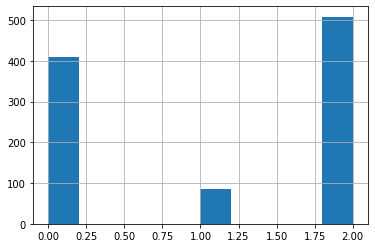

In [645]:
# predict(work_ques_all, 'positive_score_label_x', 'positive_score_label_x')
work_ques_all['positive_score_label_x'].hist()

In [671]:
# fitbit_ques1 =fitbit_ques1.dropna(subset=['value_nemuke_label'])
# fitbit_ques1=fitbit_ques1[fitbit_ques1['value_nemuke_label']!=1].hist()
# fitbit_ques1['value_nemuke_label'].replace(2,1).astype('int')
# ['value_nemuke_label'].isnull().count()
# fitbit_ques1['value_hukai_label'].hist(bins=100)
merged_work['date'] = pd.to_datetime(merged_work['date'])
merged_work = pd.merge(work_detail, work_env, on=['date','user_id'])
merged_work = merged_work.fillna(zero_td)

merged_mor_night_ques = pd.read_csv('./merged_mor_night_ques.csv')
merged_mor_night_ques = merged_mor_night_ques.rename(columns={'positive_score_label_x':'positive_score_label_m',
       'depressive_score_label_x':'depressive_score_label_m', 'anxious_score_label_x':'anxious_score_label_m',
        'value_nemuke_label_x':'value_nemuke_label_m',
       'value_hukai_label_x':'value_hukai_label_m', 'value_boyake_label_x':'value_boyake_label_m'})
merged_work = pd.read_csv('./merged_work.csv')
work_ques_all = pd.merge(merged_work, merged_mor_night_ques,left_on=['date','user_id'],right_on=['date_x','user_id'])
work_ques_all.columns

# work_mor_ques = pd.merge(merged_morning, merged_work, left_on=['merge_date','user_id'], right_on=['date','user_id'])
# work_night_ques = pd.merge(merged_night_w, merged_work, on=['date','user_id'])

Index(['Unnamed: 0_x', 'date', 'user_id', '管理者兼作業者', '企画業務',
       'ノンコア業務（自身が本来担当ではない業務）', '管理者', '比較的慣れており，定型化できている業務',
       'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務', '作業者/参加者', '管理の業務',
       '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務', '事務業務（サポート業務、経理業務など）',
       '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）', '家（その他）', 'どちらでもない', '一人',
       '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）', '快適', '職場外のワークスペース',
       '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外', '不快', '非常に快適',
       '職場外ワークスペース', '非常に不快', 'Unnamed: 0_y', 'Date_jp', 'date_x',
       'positive_score_label_m', 'depressive_score_label_m',
       'anxious_score_label_m', 'value_nemuke', 'value_hukai', 'value_boyake',
       'value_nemuke_label_m', 'value_hukai_label_m', 'value_boyake_label_m',
       'merge_date', 'date_y', 'positive_score_label_y',
       'depressive_score_label_y', 'anxious_score_label_y',
       'value_hukai_label_y', 'value_boyake_label_y', 'value_nemuke_label_y',
       'datetime_jp_x', 'value_

[[54 27]
 [ 9 93]]


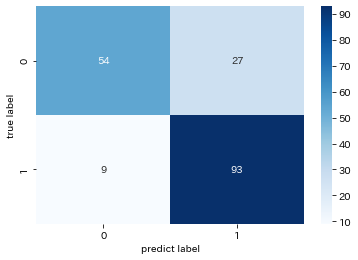

In [674]:
conf_mat(y_test, y_pred)
ques_act_day = pd.read_csv('../../datas/ques_act_merge/ques_act_day.csv')
# merged_work.to_csv('./merged_work.csv')
work_ques_all = work_ques_all[[ 'date', 'user_id', '管理者兼作業者', '企画業務',
       'ノンコア業務（自身が本来担当ではない業務）', '管理者', '比較的慣れており，定型化できている業務',
       'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務', '作業者/参加者', '管理の業務',
       '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務', '事務業務（サポート業務、経理業務など）',
       '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）', '家（その他）', 'どちらでもない', '一人',
       '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）', '快適', '職場外のワークスペース',
       '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外', '不快', '非常に快適',
       '職場外ワークスペース', '非常に不快', 
       'positive_score_label_m', 'depressive_score_label_m',
       'anxious_score_label_m', 'value_nemuke', 'value_hukai', 'value_boyake',
       'value_nemuke_label_m', 'value_hukai_label_m', 'value_boyake_label_m',
       'merge_date', 'positive_score_label_y',
       'depressive_score_label_y', 'anxious_score_label_y',
       'value_hukai_label_y', 'value_boyake_label_y', 'value_nemuke_label_y',
        'value_eval', 'hour', 'kouritu_label', 'syutyu_label',
       'yoteidori_label', 'jubun_comu_label', 'kouritu_comu_label',
       'idea_label', 'seika_label', 'study_new_label',
       'decide_doing_label', 'paformance_label', 'absent_by_problem_label',
        'value_recover_label',
       'workenga_score_label']]

In [686]:
ques_act_day = ques_act_day[['user_id', 'Date_jp', 'meeting_ftof', 
        'meal', 'working_alone',
       'hobby_break', 'housework_childcare', 'break', 'transfer',
       'web_conference', 'other', 'work_outsideduty', 
       'collaboration', 'remote_conference']]
ques_act = ques_act_day.rename(columns={'Date_jp': 'date', 'meeting_ftof': '対面会議','meal':'食事',
                            'working_alone':'単独作業','hobby_break':'趣味・休憩',
                            'housework_childcare':'家事・育児','break':'休憩（業務時間内）',
                            'transfer':'移動','web_conference':'web会議','other':'その他',
                            'work_outsideduty':'業務外作業','collaboration':'共同作業（コミュニケーションを伴う）',
                            'remote_conference':'電話（会議）'})

Index(['user_id', 'date', '対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）',
       '移動', 'web会議', 'その他', '業務外作業', '共同作業（コミュニケーションを伴う）', '電話（会議）'],
      dtype='object')

In [733]:
work_act_all = pd.merge(ques_act, work_ques_all,on=['user_id','date'],how='left')

In [734]:
from sklearn.metrics import confusion_matrix
def conf_mat(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues').set(xlabel="predict label", ylabel="true label")
    print(cm)

In [828]:
# work_act_all['対面会議']=work_act_all['対面会議'].replace('0', zero_td)
# work_act_all['対面会議'] = pd.to_timedelta(work_act_all['対面会議'])
# work_act_all['対面会議'] = work_act_all['対面会議'].dt.total_seconds()/60
labeling(all_data, 'value_eval')

,user_id,date,対面会議,食事,単独作業,趣味・休憩,家事・育児,休憩（業務時間内）,移動,web会議,...,mini_temperature,sum_rainfall,sunlight_time,ave_windspeed,max_windspeed,ave_vaporpressure,ave_cloudcover,sex,age,value_eval_label
40,7,2021-01-13,0.000000,30.000000,644.638333,0.000000,0.0000,30.0,90.000000,0.000000,...,1.1,0.0,9.3,1.8,4.6,5.7,0.3,0.0,41.0,2.0
42,9,2021-01-13,0.000000,0.000000,120.000000,0.000000,0.0000,0.0,1487.000000,0.000000,...,1.1,0.0,9.3,1.8,4.6,5.7,0.3,0.0,42.0,0.0
43,10,2021-01-13,0.000000,36.450000,322.260667,110.000067,10.0000,23.1,0.000000,299.000000,...,1.1,0.0,9.3,1.8,4.6,5.7,0.3,1.0,26.0,0.0
44,11,2021-01-13,77.316667,74.700000,143.000000,0.000000,0.0000,0.0,325.837550,0.000000,...,1.1,0.0,9.3,1.8,4.6,5.7,0.3,1.0,30.0,0.0
45,12,2021-01-13,0.000000,80.468450,441.416667,75.824267,24.3500,81.3,175.366667,48.683333,...,1.1,0.0,9.3,1.8,4.6,5.7,0.3,1.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,103,2021-01-29,0.000000,88.315550,471.756250,0.000000,311.5603,0.0,0.000000,124.713933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1484,29,2021-01-29,0.000000,50.000000,377.000000,0.000000,0.0000,0.0,166.133333,173.000000,...,0.7,0.0,7.5,3.2,6.6,4.6,4.5,1.0,36.0,0.0
1486,39,2021-01-29,0.000000,60.000000,565.000000,0.000000,135.0000,60.0,0.000000,0.000000,...,2.8,0.0,8.2,3.9,9.9,3.9,4.5,1.0,44.0,0.0
1488,43,2021-01-29,0.000000,0.000000,402.000000,0.000000,240.0000,0.0,0.000000,90.000000,...,1.7,0.0,1.4,7.7,10.4,3.8,NaN,0.0,39.0,0.0


In [829]:
# def lgbm_model()
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
import japanize_matplotlib
# ques_act_day_pred['user_id'] = ques_act_day_pred['user_id'].astype('int')
all_data_pre=all_data[all_data['positive_score_label_m']!=1]
X = all_data_pre[['対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）',
       '移動', 'web会議', 'その他', '業務外作業', '共同作業（コミュニケーションを伴う）', '電話（会議）']]
y = all_data_pre['positive_score_label_m'].replace(2,1).astype('int')

 # kfoldの分割数
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
# 学習条件を設定
params = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': {'binary_error'},
              'num_class': 1,
              'learning_rate': 0.02,
              'num_leaves': 23,
              'min_data_in_leaf': 1,
              'num_iteration': 1000,
              'verbose': 0,
              'reg_alpha':0.93,
              'reg_lambda':2.3
              }
    
acc_list = []
f1_list = []
auc_list = []
    
for train_index, test_index in skf.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
        
    # ここではvalidをモデル評価、evalをフォールドアウト検証に使う・・・分割の大きさはデータセットと相談する
    X_eval, X_valid, y_eval, y_valid = train_test_split(X_test, y_test, random_state=90, 
                                                            shuffle=True, stratify=y_test, test_size=0.3)
    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)

    # モデル評価用
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    # 学習する
    model = lgb.train(params,
                          lgb_train,
                          num_boost_round=50,
                          valid_sets=lgb_valid,
                          early_stopping_rounds=20)
        
    y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = [0 if i < 0.5 else 1 for i in y_pred_prob]
        
    # acc : 正答率
    acc = accuracy_score(y_test,y_pred)
    print('Acc :', acc)
    # f1-score
    f1 = f1_score(y_test,y_pred)
    print('f1-score :', f1)
    # logloss 
    logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
    print('logloss :', logloss)
    # AUC 
    auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
    print('AUC :', auc) 
        
    acc_list.append(acc)
    f1_list.append(f1)
    auc_list.append(auc)
        
print('Kfold平均 acc:{}, f1-score:{}, auc:{}'.format(np.mean(acc_list), 
                                                         np.mean(f1_list), 
                                                         np.mean(auc_list)))

# importanceを表示する
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=list(X.columns), columns=['importance'])
display(importance.sort_values('importance', ascending=False))
good_columns=importance.sort_values('importance', ascending=False).index[0:50]
importance.plot.bar()

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [732]:
# conf_mat(y_test, y_pred)


,user_id,date,対面会議,食事,単独作業,趣味・休憩,家事・育児,休憩（業務時間内）,移動,web会議,その他,業務外作業,共同作業（コミュニケーションを伴う）,電話（会議）
0,7,2021-01-12,0,0.044983,0.000000,0.000000,0.00,0.0,30.000000,0.0,71.223333,0.000000,0.000000,0.0
1,8,2021-01-12,0,6.866667,0.000000,45.633333,3.25,0.0,0.000000,0.0,0.000000,0.017717,0.000000,0.0
2,10,2021-01-12,0,0.010333,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
3,12,2021-01-12,0,7.967950,0.000000,0.000000,0.00,0.0,86.880667,0.0,47.286383,0.000000,0.000000,0.0
4,13,2021-01-12,0,57.242667,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,62,2021-01-29,0,0.000000,163.749867,0.000000,0.00,30.0,135.000000,0.0,0.000000,0.000000,40.026833,0.0
1135,62,2021-01-30,0,22.000000,531.000000,0.000000,80.00,50.0,0.000000,0.0,0.000000,0.000000,0.000000,10.0
1136,70,2021-01-29,0,25.000000,261.000000,187.987483,0.00,45.4,182.853700,211.2,0.000000,0.000000,0.000000,0.0
1137,95,2021-01-29,0,30.000000,400.063700,0.000000,0.00,0.0,0.000000,60.0,0.000000,0.000000,0.000000,0.0


In [393]:
def objectives(trial):
    # scikit-learnでお試しデータの準備
    X = fitbit_ques[['user_id', 'mets_mean', 'calory_mean', 'mets_median',
       'calory_median', 'mets_var', 'calory_var',  'floor_mean',
       'floor_median', 'floor_var',  'heart_mean',
       'heart_median', 'heart_var',  'minutesFairlyActive_mean',
       'minutesFairlyActive_median', 'minutesFairlyActive_var', 
       'minutesLightlyActive_mean', 'minutesLightlyActive_median',
       'minutesLightlyActive_var',  'minutesSedentary_mean',
       'minutesSedentary_median', 'minutesSedentary_var', 
       'minutesVeryActive_mean', 'minutesVeryActive_median',
       'minutesVeryActive_var',  'step_mean', 'step_median',
       'step_var', 'sleep_1', 'sleep_2', 'sleep_3']]
    y = fitbit_ques['positive_score_label_x'].replace(2,1).astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # optunaでのハイパーパラメータサーチ範囲の設定
    params = {
        #fixed
        'boosting_type':'gbdt',
        'max_depth':-1,
        'learning_rate':0.1,
        'n_estimators': 1000,
        'metric':'l2',
        
        #variable
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'reg_alpha': trial.suggest_loguniform('reg_alpha',0.001, 10),
        'reg_lambda':trial.suggest_loguniform('reg_lambda', 0.001, 10),
    }

    # LightGBMで学習+予測
    model = lgb.LGBMRegressor(**params,random_state=0)# 追加部分
    
    # kFold交差検定で決定係数を算出し、各セットの平均値を返す
    kf = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train,scoring='r2',cv=kf)   

    return scores['test_score'].mean()

import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold,cross_validate
import sklearn.datasets
import optuna
# optunaによる最適化呼び出し
opt = optuna.create_study(direction='maximize')
opt.optimize(objectives, n_trials=5)

import optuna 
# 実行結果表示
print('最終トライアル回数:{}'.format(len(opt.trials)))
print('ベストトライアル:')
trial = opt.best_trial
print('値:{}'.format(trial.value))
print('パラメータ:')
for key, value in trial.params.items():
    print('{}:{}'.format(key, value))

[I 2021-04-30 18:03:42,598] A new study created in memory with name: no-name-26034870-681d-4414-9828-c3cb497b8f9d
[I 2021-04-30 18:03:45,578] Trial 0 finished with value: 0.45791439413333307 and parameters: {'num_leaves': 293, 'reg_alpha': 0.032134638244022545, 'reg_lambda': 0.42432476478021286}. Best is trial 0 with value: 0.45791439413333307.
[I 2021-04-30 18:03:47,995] Trial 1 finished with value: 0.4569645964835567 and parameters: {'num_leaves': 165, 'reg_alpha': 0.003697029475707485, 'reg_lambda': 0.006463941146422024}. Best is trial 0 with value: 0.45791439413333307.
[I 2021-04-30 18:03:50,252] Trial 2 finished with value: 0.4663518586394928 and parameters: {'num_leaves': 253, 'reg_alpha': 0.02607189936539663, 'reg_lambda': 0.8517414627120127}. Best is trial 2 with value: 0.4663518586394928.
[I 2021-04-30 18:03:52,632] Trial 3 finished with value: 0.45961014351745816 and parameters: {'num_leaves': 247, 'reg_alpha': 0.009957724553306693, 'reg_lambda': 0.4067657881021408}. Best is 

最終トライアル回数:5
ベストトライアル:
値:0.5016392600316141
パラメータ:
num_leaves:135
reg_alpha:0.9320641627454611
reg_lambda:2.3043849572406065


In [753]:
merged_fitbit=merged_fitbit[['user_id', 'date', 'mets_mean', 'calory_mean', 'mets_median',
       'calory_median', 'mets_var', 'calory_var',  'floor_mean',
       'floor_median', 'floor_var',  'heart_mean',
       'heart_median', 'heart_var', 'minutesFairlyActive_mean',
       'minutesFairlyActive_median', 'minutesFairlyActive_var', 
       'minutesLightlyActive_mean', 'minutesLightlyActive_median',
       'minutesLightlyActive_var',  'minutesSedentary_mean',
       'minutesSedentary_median', 'minutesSedentary_var', 
       'minutesVeryActive_mean', 'minutesVeryActive_median',
       'minutesVeryActive_var',  'step_mean', 'step_median',
       'step_var',  'sleep',  'sleep_1', 'sleep_2', 'sleep_3', 'weekday']]
attribute_weather = attribute_weather[[ 'date', 'ave_temperature', 'max_temperature',
       'mini_temperature', 'sum_rainfall', 'sunlight_time', 'ave_windspeed',
       'max_windspeed', 'ave_vaporpressure', 'ave_cloudcover', 'user_id',
       'sex', 'age']]
fitbit_work_data = pd.merge(work_act_all, merged_fitbit, on=['date','user_id'],how='left')
all_data = pd.merge(fitbit_work_data, attribute_weather, on=['date','user_id'],how='left')

In [754]:
# all_data.to_csv('./all_data.csv')

## 説明変数全部で心理指標を予測

In [763]:
fitbit_columns = ['mets_mean', 'calory_mean', 'mets_median',
       'calory_median', 'mets_var', 'calory_var', 'floor_mean', 'floor_median',
       'floor_var', 'heart_mean', 'heart_median', 'heart_var',
       'minutesFairlyActive_mean', 'minutesFairlyActive_median',
       'minutesFairlyActive_var', 'minutesLightlyActive_mean',
       'minutesLightlyActive_median', 'minutesLightlyActive_var',
       'minutesSedentary_mean', 'minutesSedentary_median',
       'minutesSedentary_var', 'minutesVeryActive_mean',
       'minutesVeryActive_median', 'minutesVeryActive_var', 'step_mean',
       'step_median', 'step_var', 'sleep', 'sleep_1', 'sleep_2', 'sleep_3']
weather_columns = [ 'ave_temperature', 'max_temperature', 'mini_temperature',
       'sum_rainfall', 'sunlight_time', 'ave_windspeed', 'max_windspeed',
       'ave_vaporpressure', 'ave_cloudcover']
other_columns = ['weekday','sex','age']
work_detail_columns = ['管理者兼作業者', '企画業務', 'ノンコア業務（自身が本来担当ではない業務）', '管理者',
       '比較的慣れており，定型化できている業務', 'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務',
       '作業者/参加者', '管理の業務', '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務',
       '事務業務（サポート業務、経理業務など）', '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）', '家（その他）',
       'どちらでもない', '一人', '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）', '快適',
       '職場外のワークスペース', '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外', '不快',
       '非常に快適', '職場外ワークスペース', '非常に不快']
work_type_columns = ['対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）',
       '移動', 'web会議', 'その他', '業務外作業', '共同作業（コミュニケーションを伴う）', '電話（会議）']

mental_label = ['positive_score_label_m', 'depressive_score_label_m',
       'anxious_score_label_m', 'value_nemuke', 'value_hukai', 'value_boyake',
       'value_nemuke_label_m', 'value_hukai_label_m', 'value_boyake_label_m',
       'merge_date', 'positive_score_label_y',
       'depressive_score_label_y', 'anxious_score_label_y',
       'value_hukai_label_y', 'value_boyake_label_y', 'value_nemuke_label_y',
        'value_eval', 'hour', 'kouritu_label', 'syutyu_label',
       'yoteidori_label', 'jubun_comu_label', 'kouritu_comu_label',
       'idea_label', 'seika_label', 'study_new_label',
       'decide_doing_label', 'paformance_label', 'absent_by_problem_label',
        'value_recover_label',
       'workenga_score_label']

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's binary_error: 0.418605
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.418605
[3]	valid_0's binary_error: 0.418605
[4]	valid_0's binary_error: 0.418605
[5]	valid_0's binary_error: 0.418605
[6]	valid_0's binary_error: 0.418605
[7]	valid_0's binary_error: 0.418605
[8]	valid_0's binary_error: 0.418605
[9]	valid_0's binary_error: 0.418605
[10]	valid_0's binary_error: 0.232558
[11]	valid_0's binary_error: 0.209302
[12]	valid_0's binary_error: 0.186047
[13]	valid_0's binary_error: 0.209302
[14]	valid_0's binary_error: 0.232558
[15]	valid_0's binary_error: 0.209302
[16]	valid_0's binary_error: 0.209302
[17]	valid_0's binary_error: 0.186047
[18]	valid_0's binary_error: 0.186047
[19]	valid_0's binary_error: 0.1860

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's binary_error: 0.418605
[3]	valid_0's binary_error: 0.418605
[4]	valid_0's binary_error: 0.418605
[5]	valid_0's binary_error: 0.418605
[6]	valid_0's binary_error: 0.418605
[7]	valid_0's binary_error: 0.418605
[8]	valid_0's binary_error: 0.418605
[9]	valid_0's binary_error: 0.418605
[10]	valid_0's binary_error: 0.232558
[11]	valid_0's binary_error: 0.232558
[12]	valid_0's binary_error: 0.232558
[13]	valid_0's binary_error: 0.232558
[14]	valid_0's binary_error: 0.209302
[15]	valid_0's binary_error: 0.209302
[16]	valid_0's binary_error: 0.186047
[17]	valid_0's binary_error: 0.209302
[18]	valid_0's binary_error: 0.209302
[19]	valid_0's binary_error: 0.209302
[20]	valid_0's binary_error: 0.209302
[21]	valid_0's binary_error: 0.209302
[22]	valid_0's binary_error: 0.209302
[23]	valid_0's binary_error: 0.209302
[24]	valid_0's binary_error: 0.209302
[25]	valid_0's binary_error: 0.209302
[26]	valid_0's binary_error: 0.209302
[27]	valid_0's binary_error: 0.209302
[28]	valid_0's binar

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's binary_error: 0.232558
[20]	valid_0's binary_error: 0.255814
[21]	valid_0's binary_error: 0.255814
[22]	valid_0's binary_error: 0.255814
[23]	valid_0's binary_error: 0.255814
[24]	valid_0's binary_error: 0.255814
[25]	valid_0's binary_error: 0.255814
[26]	valid_0's binary_error: 0.255814
[27]	valid_0's binary_error: 0.255814
[28]	valid_0's binary_error: 0.255814
[29]	valid_0's binary_error: 0.232558
[30]	valid_0's binary_error: 0.232558
[31]	valid_0's binary_error: 0.232558
[32]	valid_0's binary_error: 0.232558
[33]	valid_0's binary_error: 0.232558
[34]	valid_0's binary_error: 0.232558
[35]	valid_0's binary_error: 0.209302
[36]	valid_0's binary_error: 0.209302
[37]	valid_0's binary_error: 0.209302
[38]	valid_0's binary_error: 0.209302
[39]	valid_0's binary_error: 0.209302
[40]	valid_0's binary_error: 0.209302
[41]	valid_0's binary_error: 0.209302
[42]	valid_0's binary_error: 0.209302
[43]	valid_0's binary_error: 0.209302
[44]	valid_0's binary_error: 0.209302
[45]	valid_0

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_error: 0.418605
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.418605
[3]	valid_0's binary_error: 0.418605
[4]	valid_0's binary_error: 0.418605
[5]	valid_0's binary_error: 0.418605
[6]	valid_0's binary_error: 0.418605
[7]	valid_0's binary_error: 0.418605
[8]	valid_0's binary_error: 0.418605
[9]	valid_0's binary_error: 0.418605
[10]	valid_0's binary_error: 0.232558
[11]	valid_0's binary_error: 0.232558
[12]	valid_0's binary_error: 0.232558
[13]	valid_0's binary_error: 0.209302
[14]	valid_0's binary_error: 0.209302
[15]	valid_0's binary_error: 0.209302
[16]	valid_0's binary_error: 0.209302
[17]	valid_0's binary_error: 0.232558
[18]	valid_0's binary_error: 0.232558
[19]	valid_0's binary_error: 0.232558
[20]	valid_0's binary_error: 0.232558
[21]	valid_0's binary_error: 0.232558
[22]	valid_0's binary_error: 0.209302
[23]	valid_0's binary_error: 0.209302
[24]	valid_0's binary_error: 0.209302
[25]	valid_0's binary_error: 0.20930

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's binary_error: 0.418605
[10]	valid_0's binary_error: 0.302326
[11]	valid_0's binary_error: 0.302326
[12]	valid_0's binary_error: 0.302326
[13]	valid_0's binary_error: 0.232558
[14]	valid_0's binary_error: 0.232558
[15]	valid_0's binary_error: 0.232558
[16]	valid_0's binary_error: 0.232558
[17]	valid_0's binary_error: 0.232558
[18]	valid_0's binary_error: 0.232558
[19]	valid_0's binary_error: 0.255814
[20]	valid_0's binary_error: 0.255814
[21]	valid_0's binary_error: 0.232558
[22]	valid_0's binary_error: 0.209302
[23]	valid_0's binary_error: 0.209302
[24]	valid_0's binary_error: 0.209302
[25]	valid_0's binary_error: 0.209302
[26]	valid_0's binary_error: 0.209302
[27]	valid_0's binary_error: 0.209302
[28]	valid_0's binary_error: 0.209302
[29]	valid_0's binary_error: 0.209302
[30]	valid_0's binary_error: 0.209302
[31]	valid_0's binary_error: 0.232558
[32]	valid_0's binary_error: 0.232558
[33]	valid_0's binary_error: 0.232558
[34]	valid_0's binary_error: 0.232558
[35]	valid_0'

,importance
どちらでもない,1000.655502
比較的新規性が高く，試行錯誤を伴う定型化できていない業務,425.895646
快適,423.476195
floor_var,409.210999
age,348.875080
...,...
事務業務（サポート業務、経理業務など）,0.000000
現場業務（主に肉体労働を伴うもの）,0.000000
現場（主に肉体労働を伴うもの）,0.000000
家（その他）,0.000000


<AxesSubplot:>

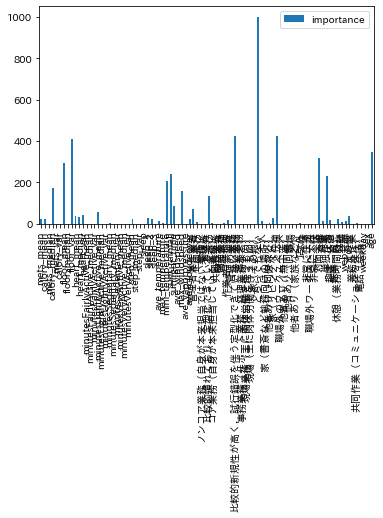

In [856]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
import japanize_matplotlib
# ques_act_day_pred['user_id'] = ques_act_day_pred['user_id'].astype('int')
target = 'workenga_score_label'

all_data_pre=all_data[all_data[target]!=1].dropna(subset=[target])
X = all_data_pre[['mets_mean', 'calory_mean', 'mets_median',
       'calory_median', 'mets_var', 'calory_var', 'floor_mean', 'floor_median',
       'floor_var', 'heart_mean', 'heart_median', 'heart_var',
       'minutesFairlyActive_mean', 'minutesFairlyActive_median',
       'minutesFairlyActive_var', 'minutesLightlyActive_mean',
       'minutesLightlyActive_median', 'minutesLightlyActive_var',
       'minutesSedentary_mean', 'minutesSedentary_median',
       'minutesSedentary_var', 'minutesVeryActive_mean',
       'minutesVeryActive_median', 'minutesVeryActive_var', 'step_mean',
       'step_median', 'step_var', 'sleep', 'sleep_1', 'sleep_2', 'sleep_3',
                  
         'ave_temperature', 'max_temperature', 'mini_temperature',
       'sum_rainfall', 'sunlight_time', 'ave_windspeed', 'max_windspeed',
       'ave_vaporpressure', 'ave_cloudcover',
        '管理者兼作業者', '企画業務', 'ノンコア業務（自身が本来担当ではない業務）', '管理者',
       '比較的慣れており，定型化できている業務', 'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務',
       '作業者/参加者', '管理の業務', '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務',
       '事務業務（サポート業務、経理業務など）', '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）', '家（その他）',
       'どちらでもない', '一人', '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）', '快適',
       '職場外のワークスペース', '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外', '不快',
       '非常に快適', '職場外ワークスペース', '非常に不快',
                 
        '対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）',
       '移動', 'web会議', 'その他', '業務外作業', '共同作業（コミュニケーションを伴う）', '電話（会議）',
        'weekday','sex','age']]
y = all_data_pre[target].replace(2,1).astype('int')

 # kfoldの分割数
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
# 学習条件を設定
params = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': {'binary_error'},
              'num_class': 1,
              'learning_rate': 0.02,
              'num_leaves': 23,
              'min_data_in_leaf': 1,
              'num_iteration': 1000,
              'verbose': 0,
              'reg_alpha':0.93,
              'reg_lambda':2.3
              }
    
acc_list = []
f1_list = []
auc_list = []
    
for train_index, test_index in skf.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
        
    # ここではvalidをモデル評価、evalをフォールドアウト検証に使う・・・分割の大きさはデータセットと相談する
    X_eval, X_valid, y_eval, y_valid = train_test_split(X_test, y_test, random_state=90, 
                                                            shuffle=True, stratify=y_test, test_size=0.3)
    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)

    # モデル評価用
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    # 学習する
    model = lgb.train(params,
                          lgb_train,
                          num_boost_round=50,
                          valid_sets=lgb_valid,
                          early_stopping_rounds=20)
        
    y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = [0 if i < 0.5 else 1 for i in y_pred_prob]
        
    # acc : 正答率
    acc = accuracy_score(y_test,y_pred)
    print('Acc :', acc)
    # f1-score
    f1 = f1_score(y_test,y_pred)
    print('f1-score :', f1)
    # logloss 
    logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
    print('logloss :', logloss)
    # AUC 
    auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
    print('AUC :', auc) 
        
    acc_list.append(acc)
    f1_list.append(f1)
    auc_list.append(auc)
        
print('Kfold平均 acc:{}, f1-score:{}, auc:{}'.format(np.mean(acc_list), 
                                                         np.mean(f1_list), 
                                                         np.mean(auc_list)))

# importanceを表示する
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=list(X.columns), columns=['importance'])
display(importance.sort_values('importance', ascending=False))
good_columns=importance.sort_values('importance', ascending=False).index[0:30]
importance.plot.bar()

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_error: 0.418605
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.418605
[3]	valid_0's binary_error: 0.418605
[4]	valid_0's binary_error: 0.418605
[5]	valid_0's binary_error: 0.418605
[6]	valid_0's binary_error: 0.418605
[7]	valid_0's binary_error: 0.418605
[8]	valid_0's binary_error: 0.418605
[9]	valid_0's binary_error: 0.418605
[10]	valid_0's binary_error: 0.209302
[11]	valid_0's binary_error: 0.232558
[12]	valid_0's binary_error: 0.232558
[13]	valid_0's binary_error: 0.232558
[14]	valid_0's binary_error: 0.232558
[15]	valid_0's binary_error: 0.232558
[16]	valid_0's binary_error: 0.186047
[17]	valid_0's binary_error: 0.186047
[18]	valid_0's binary_error: 0.186047
[19]	valid_0's binary_error: 0.162791
[20]	valid_0's binary_error: 0.186047
[21]	valid_0's binary_e

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.186047
[21]	valid_0's binary_error: 0.186047
[22]	valid_0's binary_error: 0.186047
[23]	valid_0's binary_error: 0.186047
[24]	valid_0's binary_error: 0.162791
[25]	valid_0's binary_error: 0.162791
[26]	valid_0's binary_error: 0.162791
[27]	valid_0's binary_error: 0.162791
[28]	valid_0's binary_error: 0.162791
[29]	valid_0's binary_error: 0.162791
[30]	valid_0's binary_error: 0.162791
[31]	valid_0's binary_error: 0.162791
[32]	valid_0's binary_error: 0.162791
[33]	valid_0's binary_error: 0.162791
[34]	valid_0's binary_error: 0.162791
[35]	valid_0's binary_error: 0.162791
[36]	valid_0's binary_error: 0.162791
[37]	valid_0's binary_error: 0.162791
[38]	valid_0's binary_error: 0.162791
[39]	valid_0's binary_error: 0.162791
[40]	valid_0's binary_error: 0.162791
[41]	valid_0's binary_error: 0.162791
[42]	valid_0's binary_error: 0.162791
[43]	valid_0's binary_error: 0.162791
[44]	valid_0's binary_error: 0.162791
Early stopping, best iteration is:
[24]	valid_0's 

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_error: 0.418605
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.418605
[3]	valid_0's binary_error: 0.418605
[4]	valid_0's binary_error: 0.418605
[5]	valid_0's binary_error: 0.418605
[6]	valid_0's binary_error: 0.418605
[7]	valid_0's binary_error: 0.418605
[8]	valid_0's binary_error: 0.418605
[9]	valid_0's binary_error: 0.418605
[10]	valid_0's binary_error: 0.255814
[11]	valid_0's binary_error: 0.255814
[12]	valid_0's binary_error: 0.255814
[13]	valid_0's binary_error: 0.255814
[14]	valid_0's binary_error: 0.232558
[15]	valid_0's binary_error: 0.232558
[16]	valid_0's binary_error: 0.27907
[17]	valid_0's binary_error: 0.27907
[18]	valid_0's binary_error: 0.27907
[19]	valid_0's binary_error: 0.27907
[20]	valid_0's binary_error: 0.27907
[21]	valid_0's binary_error: 0.27907
[22]	valid_0's binary_error: 0.27907
[23]	valid_0's binary_error: 0.27907
[24]	valid_0's binary_error: 0.27907
[25]	valid_0's binary_error: 0.27907
[26]	val

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's binary_error: 0.255814
[29]	valid_0's binary_error: 0.255814
[30]	valid_0's binary_error: 0.255814
[31]	valid_0's binary_error: 0.255814
[32]	valid_0's binary_error: 0.255814
[33]	valid_0's binary_error: 0.255814
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.209302
Acc : 0.7730496453900709
f1-score : 0.8350515463917526
logloss : 0.5925002061726447
AUC : 0.8762982966348152
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's binary_error: 0.418605
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.418605
[3]	valid_0's binary_error: 0.418605
[4]	valid_0's binary_error: 0.418605


/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's binary_error: 0.418605
[6]	valid_0's binary_error: 0.418605
[7]	valid_0's binary_error: 0.418605
[8]	valid_0's binary_error: 0.418605
[9]	valid_0's binary_error: 0.418605
[10]	valid_0's binary_error: 0.302326
[11]	valid_0's binary_error: 0.302326
[12]	valid_0's binary_error: 0.302326
[13]	valid_0's binary_error: 0.255814
[14]	valid_0's binary_error: 0.232558
[15]	valid_0's binary_error: 0.209302
[16]	valid_0's binary_error: 0.232558
[17]	valid_0's binary_error: 0.255814
[18]	valid_0's binary_error: 0.255814
[19]	valid_0's binary_error: 0.255814
[20]	valid_0's binary_error: 0.255814
[21]	valid_0's binary_error: 0.209302
[22]	valid_0's binary_error: 0.209302
[23]	valid_0's binary_error: 0.209302
[24]	valid_0's binary_error: 0.209302
[25]	valid_0's binary_error: 0.209302
[26]	valid_0's binary_error: 0.209302
[27]	valid_0's binary_error: 0.209302
[28]	valid_0's binary_error: 0.209302
[29]	valid_0's binary_error: 0.209302
[30]	valid_0's binary_error: 0.209302
[31]	valid_0's bi

,importance
どちらでもない,774.175301
floor_var,438.395629
対面会議,315.875801
快適,313.943818
比較的新規性が高く，試行錯誤を伴う定型化できていない業務,300.546778
age,245.030572
sum_rainfall,196.587439
単独作業,191.887179
mini_temperature,156.690261
max_windspeed,140.929279


<AxesSubplot:>

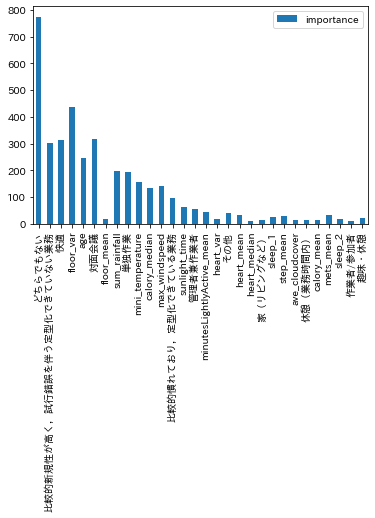

In [857]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
import japanize_matplotlib
# ques_act_day_pred['user_id'] = ques_act_day_pred['user_id'].astype('int')
target='workenga_score_label'
all_data_pre=all_data[all_data[target]!=1].dropna(subset=[target])
X = all_data_pre[good_columns]
y = all_data_pre[target].replace(2,1).astype('int')

 # kfoldの分割数
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
# 学習条件を設定
params = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': {'binary_error'},
              'num_class': 1,
              'learning_rate': 0.02,
              'num_leaves': 23,
              'min_data_in_leaf': 1,
              'num_iteration': 1000,
              'verbose': 0,
              'reg_alpha':0.93,
              'reg_lambda':2.3
              }
    
acc_list = []
f1_list = []
auc_list = []
    
for train_index, test_index in skf.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
        
    # ここではvalidをモデル評価、evalをフォールドアウト検証に使う・・・分割の大きさはデータセットと相談する
    X_eval, X_valid, y_eval, y_valid = train_test_split(X_test, y_test, random_state=90, 
                                                            shuffle=True, stratify=y_test, test_size=0.3)
    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)

    # モデル評価用
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    # 学習する
    model = lgb.train(params,
                          lgb_train,
                          num_boost_round=50,
                          valid_sets=lgb_valid,
                          early_stopping_rounds=20)
        
    y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = [0 if i < 0.5 else 1 for i in y_pred_prob]
        
    # acc : 正答率
    acc = accuracy_score(y_test,y_pred)
    print('Acc :', acc)
    # f1-score
    f1 = f1_score(y_test,y_pred)
    print('f1-score :', f1)
    # logloss 
    logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
    print('logloss :', logloss)
    # AUC 
    auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
    print('AUC :', auc) 
        
    acc_list.append(acc)
    f1_list.append(f1)
    auc_list.append(auc)
        
print('Kfold平均 acc:{}, f1-score:{}, auc:{}'.format(np.mean(acc_list), 
                                                         np.mean(f1_list), 
                                                         np.mean(auc_list)))

# importanceを表示する
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=list(X.columns), columns=['importance'])
display(importance.sort_values('importance', ascending=False))
good_columns=importance.sort_values('importance', ascending=False).index[0:30]
importance.plot.bar()

<AxesSubplot:>

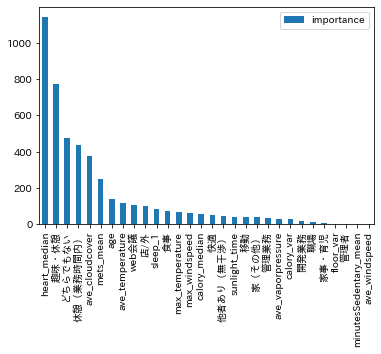

In [826]:
importance.sort_values('importance', ascending=False)[0:30].plot.bar()

In [4]:
all_importance_kind = pd.read_csv('./kind_dams_importance.csv')
all_importance_detail = pd.read_csv('./detail_dams_importance.csv')

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import japanize_matplotlib

all_importance_detail = all_importance_detail.rename(columns={
    '朝アンケートの肯定的気分':'肯定的気分（朝）'
    'importance_positive_score_label_morning':'肯定的気分（朝）',
    'importance_depressive_score_label_morning':'抑うつ気分（朝）',
    'importance_anxious_score_label_morning':'不安気分（朝）',
    'importance_positive_score_label_night':'肯定的気分（夜）',
    'importance_depressive_score_label_night':'抑うつ気分（夜）',
    'importance_anxious_score_label_night':'不安気分（夜）'})

all_importance_kind = all_importance_kind.rename(columns={
    'importance_positive_score_label_morning':'肯定的気分（朝）',
    'importance_depressive_score_label_morning':'抑うつ気分（朝）',
    'importance_anxious_score_label_morning':'不安気分（朝）',
    'importance_positive_score_label_night':'肯定的気分（夜）',
    'importance_depressive_score_label_night':'抑うつ気分（夜）',
    'importance_anxious_score_label_night':'不安気分（夜）'})
plt.figure(figsize=(16, 12))
sns.heatmap(all_importance_detail.set_index('Unnamed: 0'), annot=True, fmt='g', cmap='Purples')
plt.show()

SyntaxError: invalid syntax (<ipython-input-82-6688d500ad12>, line 9)

In [50]:
all_importance_detail=all_importance_detail.rename(columns={'朝アンケートの肯定的気分':'肯定的気分（朝）'})
all_importance_kind=all_importance_kind.rename(columns={'朝アンケートの肯定的気分':'肯定的気分（朝）'})

# all_importance_detail=all_importance_detail.set_index('Unnamed: 0')

In [51]:
all_importance_kind = all_importance_kind.set_index('Unnamed: 0')
for i in range(len(all_importance_kind.columns)):
    column = all_importance_kind.columns[i]
    print(all_importance_kind[column].sum())
    normal_imp_kind = all_importance_kind
    normal_imp_kind[column] = all_importance_kind[column]/all_importance_kind[column].sum()


KeyError: "None of ['Unnamed: 0'] are in the columns"

In [84]:
# normal_imp_detail = normal_imp_detail.reset_index().rename(columns={'Unnamed: 0':'行動の内容，環境'}).set_index('行動の内容，環境')
# normal_imp_kind = normal_imp_kind.reset_index().rename(columns={'Unnamed: 0':'行動の種類'}).set_index('行動の種類')
# normal_imp_detail
all_importance

,肯定的気分（朝）,抑うつ気分（朝）,不安気分（朝）,肯定的気分（夜）,抑うつ気分（夜）,不安気分（夜）
Unnamed: 0,,,,,,
管理者兼作業者,0.006974,0.111468,0.000000,0.016180,0.010915,0.001140
企画業務,0.048128,0.024038,0.097310,0.086163,0.038479,0.019554
ノンコア業務（自身が本来担当ではない業務）,0.058326,0.000000,0.002248,0.000000,0.000000,0.043878
管理者,0.000000,0.000000,0.000000,0.000000,0.007716,0.004266
比較的慣れており，定型化できている業務,0.032669,0.099379,0.031862,0.000000,0.015274,0.016381
コア業務（自身が本来担当している業務）,0.024428,0.009305,0.018330,0.031678,0.012187,0.062490
共同作業者,0.056346,0.000000,0.009505,0.091923,0.006625,0.008379
開発業務,0.057477,0.037718,0.037286,0.067350,0.007119,0.040278
管理業務,0.003194,0.052258,0.007543,0.000000,0.046507,0.031435


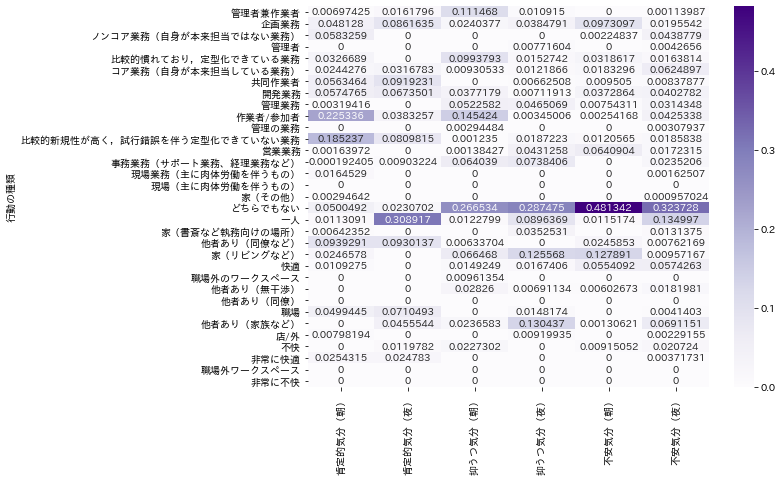

In [85]:
normal_imp_detail = all_importance_detail.reset_index().rename(columns={'Unnamed: 0':'行動の種類'}).set_index('行動の種類')
normal_imp_detail = normal_imp_detail[['肯定的気分（朝）','肯定的気分（夜）', '抑うつ気分（朝）' , '抑うつ気分（夜）', '不安気分（朝）', '不安気分（夜）']]
# normal_imp_detail = normal_imp_detail[['肯定的気分（朝）','肯定的気分（夜）', '抑うつ気分（朝）' , '抑うつ気分（夜）', '不安気分（朝）', '不安気分（夜）']]
plt.figure(figsize=(9, 7))
sns.heatmap(normal_imp_detail, annot=True, fmt='g', cmap='Purples')
plt.show()

In [91]:
morning_dams = pd.read_csv('./analyse_data/questionaire_data/morning_dams.csv')
plt.hist(morning_dams['positive_score'],bins=45)
# 縦線
# plt.vlines([morning_dams.describe()["positive_score"]["mean"]], 0, 180, "blue", linestyles='dashed')
plt.vlines([morning_dams["positive_score"].quantile(0.4), 0, 180, "red", linestyles='dashed')
# plt.vlines([morning_dams["positive_score"].quantile(0.6), 0, 180, "red", linestyles='dashed')
# morning_dams['positive_score']

SyntaxError: invalid syntax (<ipython-input-91-b1bf0eecdae3>, line 5)

In [92]:
morning_dams["positive_score"]

NameError: name 'morning_dams' is not defined

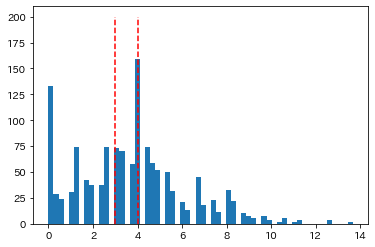

In [108]:
from matplotlib import pyplot

morning_dams = pd.read_csv('./analyse_data/questionaire_data/morning_dams.csv')
plt.hist(morning_dams['positive_score'],bins=60)
# 縦線
# plt.vlines([morning_dams.describe()["positive_score"]["mean"]], 0, 180, "blue", linestyles='dashed')
plt.vlines(morning_dams["positive_score"].quantile(0.4), 0, 200, "red", linestyles='dashed')
plt.vlines(morning_dams["positive_score"].quantile(0.6), 0, 200, "red", linestyles='dashed')
# morning_dams['positive_score']

In [115]:
all_data = pd.read_csv('./all_data.csv')
all_data1 = all_data[['管理者兼作業者', '企画業務',
       'ノンコア業務（自身が本来担当ではない業務）', '管理者', '比較的慣れており，定型化できている業務',
       'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務', '作業者/参加者', '管理の業務',
       '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務', '事務業務（サポート業務、経理業務など）',
       '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）', '家（その他）', 'どちらでもない', '一人',
       '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）', '快適', '職場外のワークスペース',
       '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外', '不快', '非常に快適',
       '職場外ワークスペース', '非常に不快']]
df_bool = (all_data != 0.00)
# df_bool.sum().hist()
# df_bool.sum().plot.bar()

axes = df_bool.plot.bar(rot=0, subplots=True)
print(axes)
plt.show()

TypeError: no numeric data to plot

In [116]:
all_data

Index(['Unnamed: 0', 'user_id', 'date', '対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児',
       '休憩（業務時間内）', '移動',
       ...
       'max_temperature', 'mini_temperature', 'sum_rainfall', 'sunlight_time',
       'ave_windspeed', 'max_windspeed', 'ave_vaporpressure', 'ave_cloudcover',
       'sex', 'age'],
      dtype='object', length=122)